In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mplt
import numpy as np


## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
mplt.rc('text', usetex=True)

In [2]:
class Nucleon(object):
    def __init__(self, pol, delta_y = 0.0 ) :
        self.n_coll = 0
        self.r = pol
        self.x = self.shifted_cartesian( delta_y )
        # r is tuple ( r, theta, phi )
        # x is tuple ( x, y, z)
    
    def shifted_cartesian(self, delta_y) :
        
        #convert to cartesian
        cx = self.r[0] * np.cos( self.r[1] ) * np.sin( self.r[2] )
        cy = self.r[0] * np.sin( self.r[2] ) * np.sin( self.r[1] )
        cz = self.r[0] * np.cos( self.r[2] )
        
        cy = cy + delta_y
        
        return (cx, cy, cz)

    def collide_with( other ) :
        # do collisions
        print "Collide_with"

class Atom(object) :
    def __init__( self, R=6.38, a=0.535, delta_y=0, nn = 197, nn_xs = 3.15 ) :
        self.wsp = WS_PDF( R, a, 0.01 )
        self.R = R
        self.a = a
        self.delta_y = delta_y
        self.nn = nn
        self.nn_xs = nn_xs
        
        self.nucleons = []

        #generate the nucleons
        for i in np.arange( 0, nn ) :
            n = Nucleon( self.wsp.r_theta_phi() )
            self.nucleons.append( n )
        
    def plot( self ) :
        rs = [item.r[0] for item in self.nucleons ]
        plt.hist( rs )
        
class Collider(object) :
    def __init__(self, b, n_events = 100, n_a = "Au", n_b = "Au", nn_xs = 3.15 ) :
        self.n_a = n_a
        self.n_b = n_b
        self.b = b
        self.n_events = n_events
        self.nn_xs = nn_xs
    def create_atoms(self ) :
        if self.b < 0 :
            b = np.random.uniform( -np.abs( self.b ), np.abs( self.b ) )
        else :
            b = self.b
        
        if "Au" == n_a :
            self.A = Atom( 6.38, 0.535, b )
        if "Au" == n_b :
            self.B = Atom( 6.38, 0.535, 0 )
    
    def collide_atoms( self ) :
        print " collide "
    def event(self) :
        # create atoms
        
        for i_event in np.arange( 0, self.n_events ) :
            self.create_atoms()
            self.collide_atoms()
        

In [49]:
class WS_PDF(object) :
    def __init__( self, R=6.38, a=0.535, res = 0.01, x_min=0, x_max=0 ) :
        self.R = R
        self.a = a
        self.res = res
        
        self.x_min = x_min
        self.x_max = x_max
        
        if x_min == 0 and x_max == 0 :
            self.x_min = -2 * R
            self.x_max = 2 * R
        
        self.norm = 1.0
        self.norm = self.n_integral( self.x_min, self.x_max, normed=False )
        
    def eval( self, r ) :
        if ( r > 0 ) :
            return 1.0 / ( 1 + np.exp( ( r - self.R)/self.a ) )
        return 1.0 / ( 1 + np.exp( ( - r - self.R)/self.a ) )

    def n_integral( self, x_min = -2.0, x_max = 2.0, normed=True  ) :
        total = 0;
        for r in np.arange( x_min, x_max, self.res ) :
            total = total + self.eval( r ) * self.res
        if True == normed :
            return total / self.norm
        return total
    
    def lookup( self, ii ) :
        total = 0;
        for r in np.arange( self.x_min, self.x_max, self.res ) :
            total = total + self.eval( r ) * self.res
            if total / self.norm >= ii :
                return r

        return self.x_max
    
    def plot( self, scale = 1.0 ) :
        x = np.arange( self.x_min, self.x_max, self.res )
        vws = np.vectorize( self.eval )
        y_max = np.max( vws(x) / self.norm )
        lines = plt.plot( x, (vws(x) / self.norm) * scale )
        plt.setp(lines, linewidth=2.5, color='b')
        plt.ylim( [0, 1.15 * y_max] )
        plt.xlabel('radius [fm]', fontsize=28)
        plt.ylabel('d(r)', fontsize=28)
        plt.title(r"\TeX\ is Number ")
    
    def plot_cdf( self, scale = 1.0 ) :
        x = np.arange( self.x_min, self.x_max, self.res )
        y = []
        for ix in x :
            y.append( self.n_integral( self.x_min, ix ) )

        plt.plot( x, y )
        plt.ylim( [0, (1.05) ] )
    
    def sample( self, N = 100 ):
        samples = []
        for i in np.arange( 0, N ) :
            r_pos = self.r_theta_phi()
            samples.append( r_pos )
        return samples
    def sample_bins( self, res = 0.0 ) :
        if 0.0 == res :
            res = self.res
        return np.linspace( self.x_min, self.x_max, (self.x_max - self.x_min)/res )
    def r_theta_phi( self ) :
        rr = self.lookup( np.random.uniform( 0, 1 ) )
        rphi = np.random.uniform( -np.pi, np.pi )
        rtheta = np.arccos( np.random.uniform( -1, 1 ) )
        
        return rr, rtheta, rphi
    
    def smearing( self, p, scale = 1.0 ) :
        r = p[0]
        theta = p[1]
        phi = p[ 2 ]
        
        xs = 3.1
        ds = np.sqrt( xs / np.pi )
        ds = ds * scale
        
        #convert to cartesian
        x = r * np.cos( theta ) * np.sin( phi )
        y = r * np.sin( phi ) * np.sin( theta )
        z = r * np.cos( phi )
        
        x = x + np.random.uniform( -ds, ds )
        y = y + np.random.uniform( -ds, ds )
        z = z + np.random.uniform( -ds, ds )
        
        rr = np.sqrt( x*x + y*y + z*z )
        if r <= 0 :
            rr = rr * -1
        rtheta = np.arccos( z/rr )
        rphi = np.arctan2( y, x )
        
        return (rr, rtheta, rphi)
        


In [9]:
atom = Atom( 6.38, 0.535, 0 )


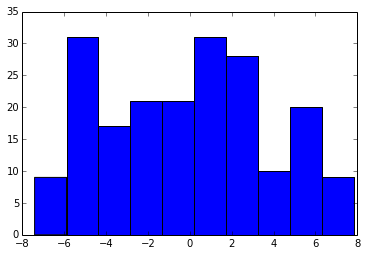

In [10]:
atom.plot()

In [50]:
wsp = WS_PDF( 6.38, 0.535, 0.01 )

## PDF

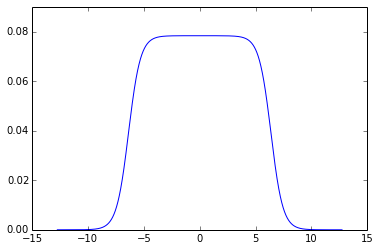

In [12]:
wsp.plot(  )

## CDF

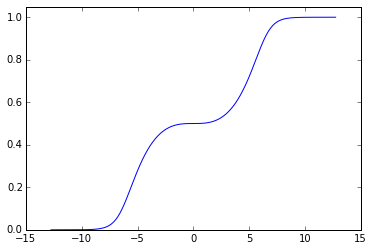

In [89]:
wsp.plot_cdf(  )

##Sampling

In [30]:
N = 19700.0
N_bins = 100
bw = (wsp.x_max - wsp.x_min) / float(N_bins)
bins = wsp.sample_bins( bw )

In [19]:
rs = wsp.sample( N )

In [20]:
rr = [item[0] for item in rs ]
# rrs = [ wsp.smearing(item, 2)[0] for item in rs ]

In [51]:
f = plt.figure( figsize=(19, 7) )
plt.hist( rr, bins=bins, normed=True, color="red" )
# plt.hist( rrs, bins=bins, normed=True, color="blue", alpha=0.5 )
wsp.plot()

RuntimeError: LaTeX was not able to process the following string:
'lp'
Here is the full report generated by LaTeX: 

This is pdfTeX, Version 3.14159265-2.6-1.40.16 (TeX Live 2015/MacPorts 2015_1) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./2e777cf6e04f9c870aaf44086038dc64.tex
LaTeX2e <2015/01/01>
Babel <3.9l> and hyphenation patterns for 2 languages loaded.
(/opt/local/share/texmf-texlive/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/opt/local/share/texmf-texlive/tex/latex/base/size10.clo))
(/opt/local/share/texmf-texlive/tex/latex/type1cm/type1cm.sty)
(/opt/local/share/texmf-texlive/tex/latex/psnfss/helvet.sty
(/opt/local/share/texmf-texlive/tex/latex/graphics/keyval.sty))
(/opt/local/share/texmf-texlive/tex/latex/psnfss/courier.sty)
(/opt/local/share/texmf-texlive/tex/latex/base/textcomp.sty
(/opt/local/share/texmf-texlive/tex/latex/base/ts1enc.def))
(/opt/local/share/texmf-texlive/tex/latex/geometry/geometry.sty
(/opt/local/share/texmf-texlive/tex/generic/oberdiek/ifpdf.sty)
(/opt/local/share/texmf-texlive/tex/generic/oberdiek/ifvtex.sty)
(/opt/local/share/texmf-texlive/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file 2e777cf6e04f9c870aaf44086038dc64.aux.
(/opt/local/share/texmf-texlive/tex/latex/base/ts1cmr.fd)
(/opt/local/share/texmf-texlive/tex/latex/psnfss/ot1pnc.fd)
! Font OT1/pnc/m/n/10=pncr7t at 10.0pt not loadable: Metric (TFM) file not foun
d.
<to be read again> 
                   relax 
l.11 \begin{document}
                     
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
(/opt/local/share/texmf-texlive/tex/latex/psnfss/ot1phv.fd)
! Font OT1/phv/m/n/10=phvr7t at 10.0pt not loadable: Metric (TFM) file not foun
d.
<to be read again> 
                   relax 
l.12 \fontsize{10.000000}{12.500000}{\sffamily
                                               lp}
[1] (./2e777cf6e04f9c870aaf44086038dc64.aux) )
(see the transcript file for additional information)
Output written on 2e777cf6e04f9c870aaf44086038dc64.dvi (1 page, 188 bytes).
Transcript written on 2e777cf6e04f9c870aaf44086038dc64.log.
